<a href="https://www.kaggle.com/code/angevalli/stochastic-linear-bandits/notebook" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>
<a href="https://drive.google.com/drive/folders/1QdD7SbYdJoq8D2hfU9b3Ld6XoGIOATwV?usp=sharing" target="_blank"><img align="left" alt="Colab" title="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"></a> 

# Imports

1) Mount Google Drive to access files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

2) Add a shortcut from the shared folder _Stochastic_Linear_Bandit_ into your Google Drive folders

3) Change current folder for the _Stochastic_Linear_Bandit_ folder (don't forget to change the file path if different)

In [ ]:
cd cd /content/drive/MyDrive/Stochastic_Linear_Bandit

# Lab on Stochastic Linear Bandits :

We provide the environment to run a standard linear bandit experiment. The objective is to understand how to implement LinUCB and its variant LinTS.

In [ ]:
import numpy as np
from model import Environment, Agent
from display import plot_regret


from scipy.stats import bernoulli
from math import log

import random
import sys
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Action generators 

In [ ]:
def randomActionsGenerator(K,d):
  """
  K: int -- number of action vectors to be generated
  d : int -- dimension of the action space
  returns : an array of K vectors uniformly sampled on the unit sphere in R^d
  """

  vecs = np.random.multivariate_normal(np.zeros(d), np.eye(d), size =K)
  norms = np.linalg.norm(vecs,axis=1)
  return vecs / norms[:,np.newaxis]

In [ ]:
a = randomActionsGenerator(100,2)

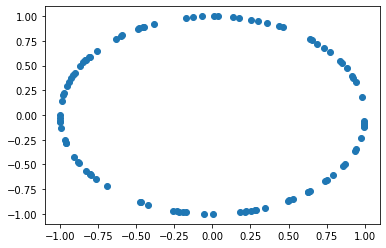

In [ ]:
plt.scatter(a[:,0],a[:,1])

# Environment Class

In [ ]:
class LinearBandit(Environment):
    
    def __init__(self, theta, K, model='gaussian', var=1.):
        """
        theta: d-dimensional vector (bounded) representing the hidden parameter
        K: number of actions per round (random action vectors generated each time)
        """
        self.model = model
        self.d = np.size(theta)
        self.theta = theta
        self.K = K
        self.var = var
        self.current_action_set = np.zeros(self.d)
        
    def get_action_set(self):
        self.current_action_set = randomActionsGenerator(self.K, self.d)
        return self.current_action_set
        
    def get_reward(self, action):
    
        """ sample reward given action and the model of this bandit environment
        action: d-dimensional vector (action chosen by the learner)
        """
        mean = np.dot(action, self.theta)
        if self.model == 'gaussian':
            return np.random.normal(mean, scale=self.var)
        else:#add bernoulli model option
            raise NotImplementedError('only Gaussian rewards are implemented so far')
            
    def get_means(self):
        return np.dot(self.current_action_set, self.theta)

# Linear Bandit Agents


## LinUCB : Implementing optimism in $R^d$

The actions are vectors in $R^d$, representing contextual features, and the environment is assumed to generate rewards according to some hidden linear function $f_\theta(a) = a^\top \theta$. The goal of the learner is thus to estimate $\theta$ while keeping a measure of the uncertainty in all the directions of the feature space. 

We first implement a LinUniform Agent that returns one of the action vectors of the action set, chosen uniformly at random. Then, we implement an LinEpsilonGreedy agent. The regret of the epsilon-greedy algorithm is linear. We can be lucky if we quickly find an optimal arm, but in general it is not the case. This gives a good basis. Our following algorithms aim at performing better than this one, and it gives a first result to compare with LinUCB and LinTS.

We implement LinUCB, which means to compute UCBs for each arm of the current action set received from the environment, but with LinUCB the exploration bonus depends on the history of taken actions and received rewards.

One key step is to invert the covariance matrix in order to compute the elliptical norm of each available action. Remark however that at round $t+1$, the new covariance matrix is very similar to the previous one at rount $t$. One way to optimize this step is to use the Sherman-Morrisson formula, as we are in the conditions where the covariance matrix is invertible and at time $t+1$ we just add the outer product $aa^\top$ where $a$ is the last chosen arm at time $t$. This formula is simpler to compute as we do not have to inverse the covariance matrix but only use the inverse of covariance matrix at time $t$ to recover covariance matrix at time $t+1$.

$$ V_{t+1} = V_t +  aa^\top \implies V_{t+1}^{-1} = (V_t +  aa^\top)^{-1} = V_t^{-1} - \frac{V_t^{-1} aa^\top V_t^{-1}}{1 + a^\top V_t^{-1} a} $$

Sherman-Morisson formula is a direct consequence from the properties of the general linear group on square matrices : adding a little perturbation to an invertible matrix is still an invertible matrix.

It is common practice to modify LinUCB by multiplying the confidence bonus of each arm by some hyperparameter $ 0<\alpha <1 $. Adding this hyperparameter $\alpha$ is a way to apply scalability over the UCB algorithm. Multiplying it to the confidence bonus is a way of penalizing the bonus part in the UCB formula, and so having $ 0<\alpha <1 $ implies to have a greedier algorithm than original UCB.
Behind this technique, we elevate the risk to compute a $\theta$ being outside the high-probability confidence region, because this was ensured by the beta component. Having $\alpha$ close to 0 means we rely more on the regularized least squares estimate of $\theta$ to make the choice of the next arm.
By discounting the bonus part, we carry less on the history of taken actions and received rewards, and in our case it is a good idea to do so as we always start by pulling a random arm at time $t=0$ and this can have a negative impact on the evolution of the algorithm. In practice, we see that a value of $\alpha$ near 0.5 produces better results than no discount at all.

In [ ]:
class LinUniform(Agent):
  def __init__(self):
    pass

  def get_action(self, arms):
    K,_ = arms.shape
    return arms[np.random.choice(K)]

  def receive_reward(self, chosen_arm, reward):
    pass

  def reset(self):
    pass

  @staticmethod
  def name(self):
    return 'Unif'

from numpy.linalg import pinv

class LinEpsilonGreedy(Agent):
  def __init__(self, d, lambda_reg, epsilon=1e-1):
    self.epsilon = epsilon
    self.d = d
    self.used_arms = []
    self.lambda_reg = lambda_reg
    self.V = np.zeros(self.d)
    self.b = np.zeros(self.d)
    self.t = 0

  def get_action(self, arms):
        #implement epsilon-greedy:
        K, _ = arms.shape
        
        ## A l'initialisation, on choisit également un bras au hasard
        if self.t == 0 or np.random.random() < self.epsilon :
            chosen_arm = arms[np.random.randint(0,high=K)]

        else:
            self.V = (np.array([
                    np.outer(ai,ai.transpose()) for ai in self.used_arms
                    ]).sum(axis=0)
                    + self.lambda_reg*np.eye(self.d))

            theta_hat = pinv(self.V)@self.b
            thetas = [theta_hat.transpose() @ arm for arm in arms]
            chosen_arm = arms[np.argmax(thetas)]
        
        # Update memory
        self.t += 1
        self.used_arms.append(chosen_arm)

        return chosen_arm

  def receive_reward(self, chosen_arm, reward):
    self.b += reward*chosen_arm

  def reset(self):
    self.t = 0

  @staticmethod
  def name(self):
    return 'eps-greedy('+str(self.epsilon)+')'

class LinUCB(Agent):

  def __init__(self, T, d, delta, lambda_reg, alpha=1):
    """
    T : Number of done actions for the calculation of thetas
    d : Dimension of action
    delta : Probability of theta non being within the high-confidence region
    lambda_reg : Regularization parameter of theta norm
    alpha : Scale factor of the exploration bonus
    """
    self.T = T
    self.d = d
    self.delta = delta
    self.lambda_reg = lambda_reg
    self.b = np.zeros(self.d)
    self.V = self.lambda_reg*np.zeros(self.d)
    self.alpha = alpha
    self.used_arms = []
    self.UCBs = np.zeros(K)
    # We compute the list of betas at initialisation
    # so we don't have to compute it at each round
    self.list_betas = [
      (np.sqrt(self.lambda_reg)
      + np.sqrt(2*np.log(1/self.delta)
      + self.d*np.log((self.lambda_reg*self.d+t)/(self.lambda_reg*self.d)))
      ) for t in range(self.T)]

    self.reset()

  def reset(self):
    # reset all local variables that should not be kept when the experiment is restarted
    self.t = 0
    self.b = np.zeros(self.d)
    self.V = self.lambda_reg*np.zeros(self.d)
    self.used_arms = []

  def get_action(self, arms):
    """
        This function implements LinUCB
        Input:
        -------
        arms : List of arms (d-dimensional vectors)

        Output:
        -------
        chosen_arm : The pulled arm vector
        """

    K, _ = arms.shape
    if self.t == 0 :
      chosen_arm = arms[np.random.randint(0,high=K)]
    else :
      self.UCBs = np.zeros(K)
      
      self.V = (np.array([
        np.outer(ai,ai.transpose()) for ai in self.used_arms
        ]).sum(axis=0)
        + self.lambda_reg*np.eye(self.d)
      )
      theta_hat = pinv(self.V).dot(self.b)
      self.UCBs = [
        (theta_hat.transpose()@arms[i]
        + self.alpha*self.list_betas[self.t]
        * np.sqrt(arms[i].transpose()@pinv(self.V)@arms[i])
        ) for i in range(K)]
      chosen_arm=arms[np.argmax(self.UCBs)]

    self.t += 1
    self.used_arms.append(chosen_arm)
    return chosen_arm   

  def receive_reward(self, chosen_arm, reward):
    self.b += reward*chosen_arm

  def name(self):
    return "LinUCB_alpha=" + str(self.alpha) + "_lambda_reg=" + str(self.lambda_reg)

## LinTS : Taking the Bayesian way

Thompson Sampling is a popular bayesian alternative to the standard optimistic bandit algorithms (see Chapter 36 of Bandit Algorithms). The key idea is to rely on Bayesian *samples* to get a proxy for the hidden parameter $\theta$ of the problem instead of building high-probability confidence regions. Let us place a Gaussian prior with mean $\mathbf{0}$ and covariance $\sigma_0 I$ on $\theta$. Given actions $A_1,\ldots,A_t$ and rewards $Y_1,\ldots,Y_t$, we can compute the expression of the posterior at the beginning of round $t+1$ by relying on the derivation of Bayesian Linear Regression, which gives us the posterior predictive distribution knowing the history of Actions and Rewards. We obtain that $\theta$ is a multivariate Gaussian distribution.


*Reference* : Slide 9 of CSC 411 Lecture 19 on Bayesian Linear Regression given by Roger Grosse, Amir-massoud Farahmand, and Juan Carrasquilla from University of Toronto.

In [ ]:
class LinTS(Agent):

  def __init__(self, T, d, delta, lambda_reg, sigma_0=1):
    """
    T : Number of done actions for the calculation of thetas
    d : Dimension of action
    delta : Probability of theta non being within the high-confidence region
    lambda_reg : Regularization parameter of theta norm
    sigma_0 : Covariance parameter
    """
    self.t = 0
    self.d = d
    self.b = np.zeros(self.d)
    self.sigma_0 = sigma_0
    self.cov_matrix_theta_prior = self.sigma_0*np.eye(self.d)
    self.mu_posterior = 0
    self.sigma_matrix = np.eye(self.d)
    self.sigma_posterior = pinv(self.sigma_matrix)
    self.sigma_environment = 1

  def reset(self):
    # reset all local variables that should not be kept when the experiment is restarted
    self.cov_matrix_theta_prior = self.sigma_0*np.eye(self.d)
    self.mu_posterior = 0
    self.sigma_matrix = np.eye(self.d)
    self.sigma_posterior = pinv(self.sigma_matrix)
    self.t = 0
    self.b = np.zeros(self.d)
    
  def get_action(self, arms):
        
    K, _ = arms.shape
    if self.t == 0 :
      chosen_arm = arms[np.random.randint(0,high=K)]
    else :
      thetas = np.random.multivariate_normal(
          self.mu_posterior, self.sigma_posterior
          )
      chosen_arm = arms[np.argmax(arms@thetas)]
    
    self.t += 1
    self.sigma_matrix += (self.sigma_environment ** (-2)
        * np.outer(chosen_arm, chosen_arm)
        + pinv(self.cov_matrix_theta_prior))
    self.sigma_posterior = pinv(self.sigma_matrix)
    self.mu_posterior = (self.sigma_environment ** (-2)
        * self.sigma_posterior @ self.b)

    return chosen_arm

  def receive_reward(self, chosen_arm, reward):
    self.b += reward*chosen_arm

  def name(self):
    return "LinTS_sigma0=" + str(self.sigma_0)

The function play runs one path of regret for one agent. The function experiment runs all agents several (Nmc) times and returns all the logged data. Feel free to check the inputs and outputs required when you decide on the implementation of your own agents.

In [ ]:
def play(environment, agent, Nmc, T):
    
    data = np.zeros((Nmc, T))
    
    for n in range(Nmc):
        agent.reset()
        for t in range(T):
            action_set = environment.get_action_set()
            action = agent.get_action(action_set)
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)
            
            # compute instant regret
            means = environment.get_means()
            best_reward = np.max(means)
            data[n,t]= best_reward - reward
            
    return agent.name(), data


def experiment(environment, agents, Nmc, T):
    
    all_data = {}
    
    for agent in agents:
        agent_id, regrets = play(environment, agent,Nmc, T)
        
        all_data[agent_id] = regrets
        
    return all_data

# Example: LinUCB versus LinUniform

In [ ]:
# import time

d = 2  # dimension
K = 8  # number of arms

# parametor vector \theta, normalized :
#theta = np.random.randint(2, size=d)
#while theta.sum() == 0 :
#  theta = np.random.randint(2, size=d)
#theta = theta / np.linalg.norm(theta)
theta = randomActionsGenerator(1,d)[0]

T = 1000  # Finite Horizon
N = 10  # Monte Carlo simulations

delta = 0.1

# save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub)

#choice of quantile display
q = 10

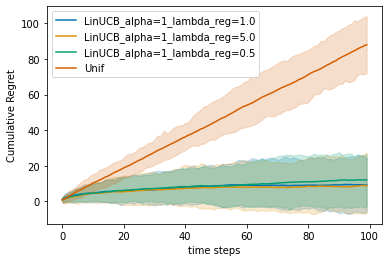

In [ ]:
basicGaussianBandit = LinearBandit(theta, K)

agent1 = LinUCB(T, d, delta, lambda_reg=1.)
agent2 = LinUCB(T, d, delta, lambda_reg=5.)
agent3 = LinUCB(T, d, delta, lambda_reg=0.5)
agent4 = LinUniform()
#agent5 = LinEpsilonGreedy(d, lambda_reg=1., epsilon=1e-1*2)

# Add agent5 as well to visualise the LinEpsilonGreedy curves
all_data = experiment(basicGaussianBandit, [agent1, agent2, agent3, agent4], Nmc=100, T=100)

plot_regret(all_data)

LinUCB takes as input a parameter **$\lambda_{reg}$** that controls the regularisation in the Least Squares Estimation. Choosing it is not easy and there is no clear rule, so we need to see experimentally if it impacts the results. One way us to run a few LinUCB with different **$\lambda_{reg}$** values and plot the results.

After having plotted multiple runs with **$\lambda_{reg}$** parameter equals to **0.5**, **1** and **5**, we can assume that the importance of this regularization depends mostly on the behaviour of the algorithm at the beginning. If the value is too high, it means that the regularization is too strong so the update of $\theta$ does not rely enough on the history of the actions taken. In our case, a standard value of **$\lambda_{reg}$ = 1** is efficient enough to obtain a convenient result. To obtain statistically significant results with these highly stochastic algorithms, we need to execute enough runs for each of them (parameter `Nmc`). Hence, the error around the computed means is reduced.

# LinUCB with $\alpha$ scaling



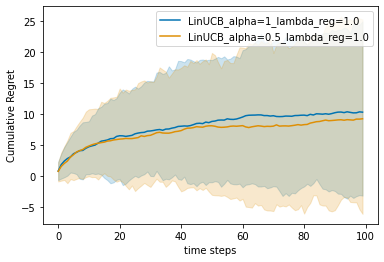

In [ ]:
basicGaussianBandit = LinearBandit(theta, K)
agent1 = LinUCB(T, d, delta, lambda_reg=1.)
agent2 = LinUCB(T, d, delta, lambda_reg=1., alpha=0.5)

all_data = experiment(basicGaussianBandit, [agent1, agent2], Nmc=100, T=100)

plot_regret(all_data)

It shows that a smaller $\alpha$ leads to more exploitation-oriented learning. We observe a similar phenomenon with the $\epsilon$ in an $\epsilon$-greedy algorithm: a very low value of epsilon favors exploitation. The first iterations do not favor these low values because the algorithm exploits non-optimal arms, which increases the regret. However, after 20 or 30 iterations for $\alpha=0.5$, the curve is maintained rather low, whereas $\alpha=1.0$ continues to explore a little more and increases the regret in this part. In a nutshell, we should favor a rather low value of $\alpha$ for long-term computation. If we have very few steps (less than 10 for example), we would choose a higher $\alpha$) to minimize the regret.


# LinTS versus LinUCB


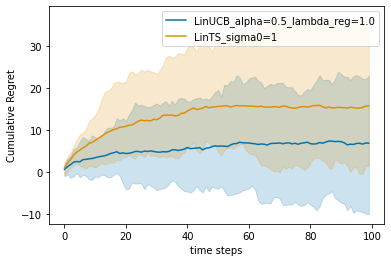

In [ ]:
basicGaussianBandit = LinearBandit(theta, K)
agent1 = LinUCB(T, d, delta, lambda_reg=1., alpha=.5)
agent2 = LinTS(T, d, delta, lambda_reg=1., sigma_0=1)

all_data = experiment(basicGaussianBandit, [agent1, agent2], Nmc=30, T=100)

plot_regret(all_data)

Globally, the results are similar, with LinUCB and a scaled bonus with $\alpha=0.5$ result showing a little better results (so a lower regret). It could be confirmed by testing it on more examples (increasing `Nmc`), for these algorithms are still highly stochastic. Furthermore, we saw two different way to fine-tune the exploitation/exploration trade-off. On the one hand, in UCB algorithm, the exploration is tuned by a scale factor $\alpha$. This method is mainly based on a frequentist point of view. On the other hand, Thompson-Sampling algorithm has a Bayesian approach and is tuned by a parameter $\sigma_0$ and tends to explore more heterogeneously. In our bandit problem, we see that both approaches are efficient to obtain a low regret.